In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install librosa


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style 
plt.style.use('ggplot') 
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Specify the new directory path to the RAVDESS dataset on Kaggle
# dataset_dir = '/kaggle/input/speech-emotion-recognition-hindi'
dataset_dir = './Hindi_dataset'

paths = []
labels = []

# Walk through the dataset directory
for dirname, _, filenames in os.walk(dataset_dir):
    for filename in filenames:
        # Extract the emotion label from the filename
        label = filename.split('_')[-1]
        # Remove the file extension if it's present
        label = label.split('.')[0].lower()
        
        # Append the full file path to paths and the extracted label to labels
        paths.append(os.path.join(dirname, filename))
        labels.append(label)

print('Dataset is Loaded')

Dataset is Loaded


In [4]:
len(paths)

3200

In [5]:
paths[:7]

['./Hindi_dataset\\1\\session1\\anger\\1.1.anger-01.wav',
 './Hindi_dataset\\1\\session1\\anger\\1.1.anger-02.wav',
 './Hindi_dataset\\1\\session1\\anger\\1.1.anger-03.wav',
 './Hindi_dataset\\1\\session1\\anger\\1.1.anger-04.wav',
 './Hindi_dataset\\1\\session1\\anger\\1.1.anger-05.wav',
 './Hindi_dataset\\1\\session1\\anger\\1.1.anger-06.wav',
 './Hindi_dataset\\1\\session1\\anger\\1.1.anger-07.wav']

In [6]:
data, sampling_rate = librosa.load('Hindi_dataset/1/session1/anger/1.1.anger-01.wav')

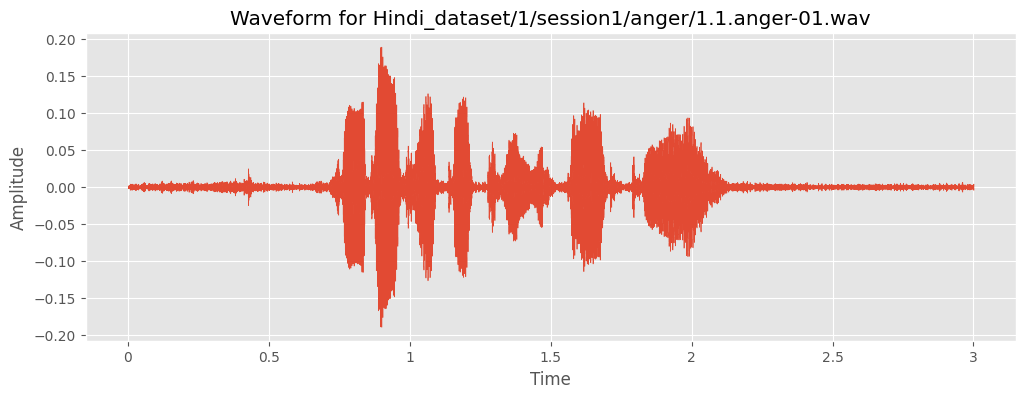

In [7]:
#Plotting the audio file's waveform
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(12, 4))
plt.grid('on')
plt.ylabel("Amplitude")
plt.title("Waveform for Hindi_dataset/1/session1/anger/1.1.anger-01.wav")
librosa.display.waveshow(data, sr=sampling_rate)
plt.show()

In [8]:
import soundfile
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split
import glob

# all emotions in the new dataset
int2emotion_new = {
    "anger": "angry",
    "sad": "sad",
    "happy": "happy",
    "neutral": "calm"
}

# we allow only these four emotions
AVAILABLE_EMOTIONS_NEW = set(int2emotion_new.values())

def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
    Features supported:
        - MFCC (mfcc)
        - Chroma (chroma)
        - MEL Spectrogram Frequency (mel)
        - Contrast (contrast)
        - Tonnetz (tonnetz)
    e.g:
    `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
            
        result = np.array([])
        
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))
            
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))
            
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, contrast))
            
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)
            result = np.hstack((result, tonnetz))
            
    return result

def load_data_new(test_size=0.2):
    X, y = [], []
   
    try:
        dataset_path = 'Hindi_dataset/**/*.wav'

        for file_name in glob.glob(dataset_path, recursive=True):
            # get the emotion label from the path
            emotion_folder = os.path.basename(os.path.dirname(file_name))
            emotion = int2emotion_new.get(emotion_folder)
            
            # check if the emotion is in the allowed set
            if emotion not in AVAILABLE_EMOTIONS_NEW:
                continue

            # extract speech features
            features = extract_feature(file_name, mfcc=True, chroma=True, mel=True)
       
            # add to data
            X.append(features)
            y.append(emotion)
       
    except Exception as e:
        print(f"Error: {e}")
     
    # split the data to training and testing and return it
    return train_test_split(np.array(X), y, test_size=test_size, random_state=7)

X_train_new, X_test_new, y_train_new, y_test_new = load_data_new()


In [9]:
print("[+] Number of training samples:", X_train_new.shape[0])
print("[+] Number of testing samples:", X_test_new.shape[0])
print("[+] Number of features:", X_train_new.shape[1])

[+] Number of training samples: 1280
[+] Number of testing samples: 320
[+] Number of features: 140


**DECISION TREE**

[+] Accuracy: 0.615625
[+] Classification Report:
              precision    recall  f1-score   support

       happy       0.56      0.47      0.51        78
       angry       0.67      0.72      0.69        81
        calm       0.54      0.58      0.56        79
         sad       0.67      0.68      0.68        82

    accuracy                           0.62       320
   macro avg       0.61      0.61      0.61       320
weighted avg       0.61      0.62      0.61       320



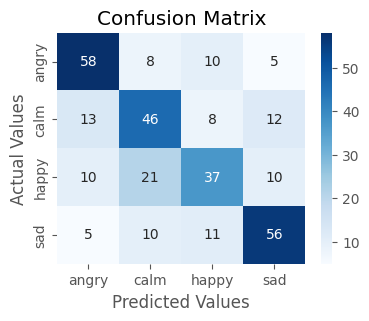

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Train the Decision Tree model
dtree_model = DecisionTreeClassifier(max_depth=15).fit(X_train_new, y_train_new)
dtree_predictions = dtree_model.predict(X_test_new)

# Print accuracy and classification report
print("[+] Accuracy:", accuracy_score(y_true=y_test_new, y_pred=dtree_predictions))
print("[+] Classification Report:")
print(classification_report(y_test_new, dtree_predictions, labels=list(AVAILABLE_EMOTIONS_NEW)))

# Create and display the confusion matrix
emotions = ["angry", "calm", "happy", "sad"]
# emotions = ["angry", "calm", "happy", "sad", "fear", "disgust", "sarcastic", "surprise"]
cm = confusion_matrix(y_test_new, dtree_predictions, labels=emotions)
cm_df = pd.DataFrame(cm, index=emotions, columns=emotions)
plt.figure(figsize=(4, 3))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


**SVM**

[+] Accuracy: 0.58125
[+] Classification Report:
              precision    recall  f1-score   support

       happy       0.70      0.70      0.70        81
       angry       0.43      0.56      0.49        79
        calm       0.50      0.38      0.43        78
         sad       0.72      0.67      0.70        82

    accuracy                           0.58       320
   macro avg       0.59      0.58      0.58       320
weighted avg       0.59      0.58      0.58       320



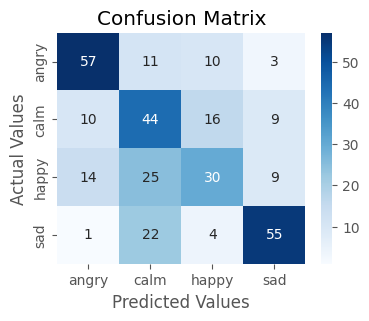

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Train the SVM model with a linear kernel
svm_model_linear = SVC(kernel='linear', C=3).fit(X_train_new, y_train_new)
svm_predictions = svm_model_linear.predict(X_test_new)

# Print accuracy and classification report
print("[+] Accuracy:", accuracy_score(y_true=y_test_new, y_pred=svm_predictions))
print("[+] Classification Report:")
print(classification_report(y_test_new, svm_predictions, target_names=AVAILABLE_EMOTIONS_NEW))

# Create and display the confusion matrix
emotions = ["angry", "calm", "happy", "sad"]
# emotions = ["angry", "calm", "happy", "sad", "fear", "disgust", "sarcastic", "surprise"]
cm = confusion_matrix(y_test_new, svm_predictions, labels=emotions)
cm_df = pd.DataFrame(cm, index=emotions, columns=emotions)
plt.figure(figsize=(4, 3))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


[+] Accuracy: 0.396875
[+] Classification Report:
              precision    recall  f1-score   support

       happy       0.70      0.41      0.52        81
       angry       0.59      0.13      0.21        79
        calm       0.67      0.05      0.10        78
         sad       0.32      0.98      0.48        82

    accuracy                           0.40       320
   macro avg       0.57      0.39      0.33       320
weighted avg       0.57      0.40      0.33       320



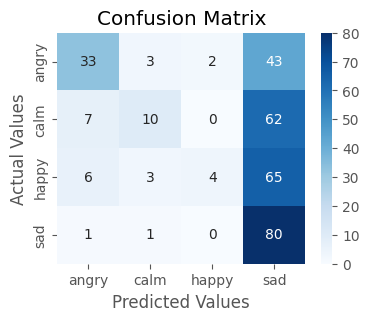

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Train the SVM model with a polynomial kernel
svm_model_poly = SVC(kernel='poly', degree=5).fit(X_train_new, y_train_new)
svm_predictions = svm_model_poly.predict(X_test_new)

# Print accuracy and classification report
print("[+] Accuracy:", accuracy_score(y_true=y_test_new, y_pred=svm_predictions))
print("[+] Classification Report:")
print(classification_report(y_test_new, svm_predictions, target_names=AVAILABLE_EMOTIONS_NEW))

# Create and display the confusion matrix
emotions = ["angry", "calm", "happy", "sad"]
# emotions = ["angry", "calm", "happy", "sad", "fear", "disgust", "sarcastic", "surprise"]

cm = confusion_matrix(y_test_new, svm_predictions, labels=emotions)
cm_df = pd.DataFrame(cm, index=emotions, columns=emotions)
plt.figure(figsize=(4, 3))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


[+] Accuracy: 0.5125
[+] Classification Report:
              precision    recall  f1-score   support

       happy       0.76      0.62      0.68        81
       angry       0.62      0.29      0.40        79
        calm       0.45      0.27      0.34        78
         sad       0.41      0.85      0.56        82

    accuracy                           0.51       320
   macro avg       0.56      0.51      0.49       320
weighted avg       0.56      0.51      0.49       320



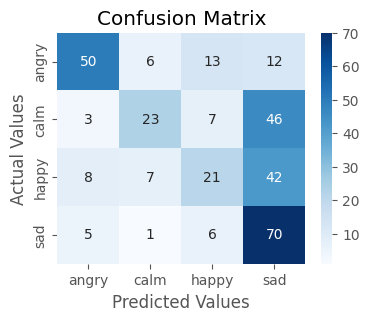

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Train the SVM model with a linear kernel
svm_model_linear = SVC().fit(X_train_new, y_train_new)
svm_predictions = svm_model_linear.predict(X_test_new)

# Print accuracy and classification report
print("[+] Accuracy:", accuracy_score(y_true=y_test_new, y_pred=svm_predictions))
print("[+] Classification Report:")
print(classification_report(y_test_new, svm_predictions, target_names=AVAILABLE_EMOTIONS_NEW))

# Create and display the confusion matrix
emotions = ["angry", "calm", "happy", "sad"]
# emotions = ["angry", "calm", "happy", "sad", "fear", "disgust", "sarcastic", "surprise"]


cm = confusion_matrix(y_test_new, svm_predictions, labels=emotions)
cm_df = pd.DataFrame(cm, index=emotions, columns=emotions)
plt.figure(figsize=(4, 3))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


**KNN**

Accuracy: 0.684375


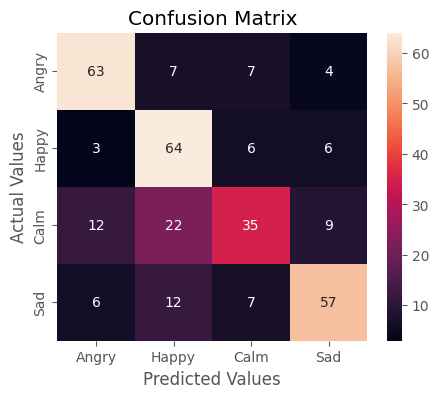

Classification Report:
               precision    recall  f1-score   support

       Angry       0.75      0.78      0.76        81
       Happy       0.61      0.81      0.70        79
        Calm       0.64      0.45      0.53        78
         Sad       0.75      0.70      0.72        82

    accuracy                           0.68       320
   macro avg       0.69      0.68      0.68       320
weighted avg       0.69      0.68      0.68       320



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming X_train_new, y_train_new, X_test_new, and y_test_new are defined for the new dataset

# Training a KNN classifier
knn = KNeighborsClassifier(n_neighbors=7).fit(X_train_new, y_train_new)

# Accuracy on X_test_new
accuracy = knn.score(X_test_new, y_test_new)
print("Accuracy:", accuracy)

# Creating a confusion matrix
knn_predictions = knn.predict(X_test_new)
cmm = confusion_matrix(y_test_new, knn_predictions)

# Printing confusion matrix
emotions = ["Angry", "Happy", "Calm", "Sad"]
# emotions = ["angry", "calm", "happy", "sad", "fear", "disgust", "sarcastic", "surprise"]

cm_df = pd.DataFrame(cmm, index=emotions, columns=emotions)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Printing classification report
report = classification_report(y_test_new, knn_predictions, target_names=emotions)
print("Classification Report:\n", report)


**RANDOM FOREST**

Accuracy: 0.734375
Classification Report:
               precision    recall  f1-score   support

       angry       0.76      0.84      0.80        81
        calm       0.65      0.76      0.70        79
       happy       0.70      0.54      0.61        78
         sad       0.82      0.79      0.81        82

    accuracy                           0.73       320
   macro avg       0.73      0.73      0.73       320
weighted avg       0.74      0.73      0.73       320



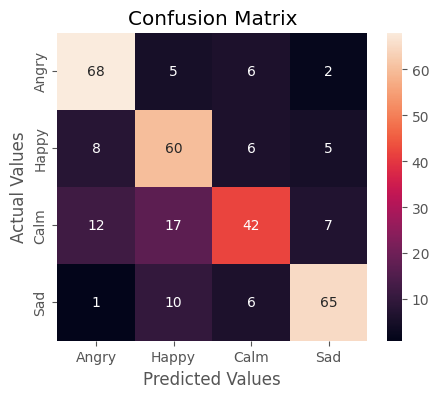

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming X_train_new, y_train_new, X_test_new, and y_test_new are defined for the new dataset

# Create RandomForestClassifier object
classifier = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit the classifier with X_train_new and y_train_new data
classifier.fit(X_train_new, y_train_new)

# Predict on X_test_new
predictions = classifier.predict(X_test_new)

# Print accuracy and classification report
print("Accuracy:", accuracy_score(y_true=y_test_new, y_pred=predictions))
print("Classification Report:\n", classification_report(y_test_new, predictions))

# Create and display the confusion matrix
emotions = ["Angry", "Happy", "Calm", "Sad"]
# emotions = ["angry", "calm", "happy", "sad", "fear", "disgust", "sarcastic", "surprise"]

cm = confusion_matrix(y_test_new, predictions)
cm_df = pd.DataFrame(cm, index=emotions, columns=emotions)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


Accuracy: 0.7625
Classification Report:
               precision    recall  f1-score   support

       angry       0.76      0.88      0.81        97
        calm       0.68      0.70      0.69       100
       happy       0.76      0.64      0.70       100
         sad       0.85      0.83      0.84       103

    accuracy                           0.76       400
   macro avg       0.76      0.76      0.76       400
weighted avg       0.76      0.76      0.76       400

Saved model to result/random_forest_model.joblib


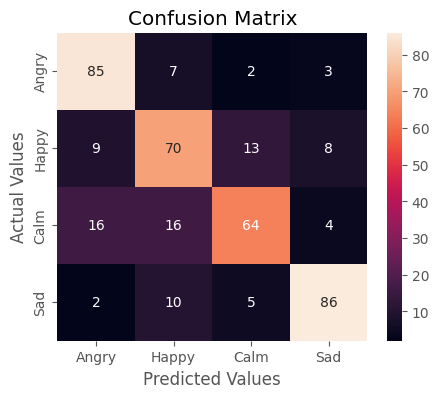

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import joblib  # Import joblib

# Assuming X_train_new, y_train_new, X_test_new, and y_test_new are defined for the new dataset

# Create RandomForestClassifier object
classifier = RandomForestClassifier(n_estimators=150, random_state=0)

# Fit the classifier with X_train_new and y_train_new data
classifier.fit(X_train_new, y_train_new)

# Predict on X_test_new
predictions = classifier.predict(X_test_new)

# Print accuracy and classification report
print("Accuracy:", accuracy_score(y_true=y_test_new, y_pred=predictions))
print("Classification Report:\n", classification_report(y_test_new, predictions))

# Create and display the confusion matrix
emotions = ["Angry", "Happy", "Calm", "Sad"]
# emotions = ["angry", "calm", "happy", "sad", "fear", "disgust", "sarcastic", "surprise"]

model_filename = "result/random_forest_model.joblib"  # Changed to .joblib
joblib.dump(classifier, model_filename)
print(f"Saved model to {model_filename}")


cm = confusion_matrix(y_test_new, predictions)
cm_df = pd.DataFrame(cm, index=emotions, columns=emotions)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


**MLP**

In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import os
import pickle


In [22]:
import soundfile
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split
import glob

# Define int2emotion_new, AVAILABLE_EMOTIONS_NEW, extract_feature, and load_data_new functions

# all emotions in the new dataset
int2emotion_new = {
    "anger": "angry",
    "sad": "sad",
    "happy": "happy",
    "neutral": "calm"
}

# we allow only these four emotions
AVAILABLE_EMOTIONS_NEW = set(int2emotion_new.values())

def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
    Features supported:
        - MFCC (mfcc)
        - Chroma (chroma)
        - MEL Spectrogram Frequency (mel)
        - Contrast (contrast)
        - Tonnetz (tonnetz)
    e.g:
    `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
            
        result = np.array([])
        
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))
            
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))
            
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, contrast))
            
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)
            result = np.hstack((result, tonnetz))
            
    return result

def load_data_new(test_size=0.2):
    X, y = [], []
   
    try:
        dataset_path = 'Hindi_dataset/**/*.wav'

        for file_name in glob.glob(dataset_path, recursive=True):
            # get the emotion label from the path
            emotion_folder = os.path.basename(os.path.dirname(file_name))
            emotion = int2emotion_new.get(emotion_folder)
            
            # check if the emotion is in the allowed set
            if emotion not in AVAILABLE_EMOTIONS_NEW:
                continue

            # extract speech features
            features = extract_feature(file_name, mfcc=True, chroma=True, mel=True)
       
            # add to data
            X.append(features)
            y.append(emotion)
       
    except Exception as e:
        print(f"Error: {e}")
     
    # split the data to training and testing and return it
    return train_test_split(np.array(X), y, test_size=test_size,random_state=7)

X_train_new, X_test_new, y_train_new, y_test_new = load_data_new()



# Load data using the provided load_data_new function
data_new = load_data_new(test_size=0.25)

# Unpack the data
X_train_new, X_test_new, y_train_new, y_test_new = data_new

# Print details
print("[+] Number of training samples:", X_train_new.shape[0])
print("[+] Number of testing samples:", X_test_new.shape[0])
print("[+] Number of features:", X_train_new.shape[1])


# Cell 2: MLP Model
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import pickle

# Define model parameters
model_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08,
    'hidden_layer_sizes': (300,),
    'learning_rate': 'adaptive',
    'max_iter': 500,
}

# Initialize and train the MLP model
print("[*] Training the MLP model...")
mlp_model = MLPClassifier(**model_params)
mlp_model.fit(X_train_new, y_train_new)

# Predict on test data
y_pred_new = mlp_model.predict(X_test_new)

# Calculate accuracy
accuracy_new = accuracy_score(y_true=y_test_new, y_pred=y_pred_new)
print("Accuracy: {:.2f}%".format(accuracy_new * 100))

# Save the MLP model
if not os.path.isdir("result"):
    os.mkdir("result")

mlp_model_save_path = "result/mlp_classifier.model"
pickle.dump(mlp_model, open(mlp_model_save_path, "wb"))
print(f"MLP Model saved at {mlp_model_save_path}")


[+] Number of training samples: 1200
[+] Number of testing samples: 400
[+] Number of features: 140
[*] Training the MLP model...
Accuracy: 71.25%
MLP Model saved at result/mlp_classifier.model


In [23]:
# Assuming X_train and y_train are defined

# Initialize Multi-Layer Perceptron classifier
model_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08,
    'hidden_layer_sizes': (300,),
    'learning_rate': 'adaptive',
    'max_iter': 500,
}

mlp_model = MLPClassifier(**model_params)

# Train the model
print("[*] Training the MLP model...")
mlp_model.fit(X_train_new, y_train_new)

# Predict on test data
y_pred = mlp_model.predict(X_test_new)

# Calculate accuracy
accuracy = accuracy_score(y_true=y_test_new, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))


[*] Training the MLP model...
Accuracy: 71.25%


              precision    recall  f1-score   support

       angry       0.76      0.76      0.76        97
        calm       0.70      0.73      0.72       100
       happy       0.63      0.62      0.62       100
         sad       0.77      0.74      0.75       103

    accuracy                           0.71       400
   macro avg       0.71      0.71      0.71       400
weighted avg       0.71      0.71      0.71       400



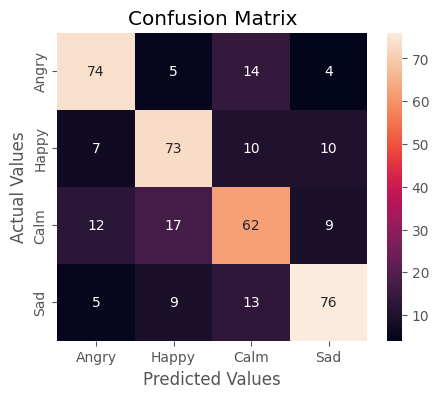

In [24]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
print(classification_report(y_test_new,y_pred))
cm=confusion_matrix(y_test_new,y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Angry','Happy','Calm', 'Sad'],
                     columns = ['Angry','Happy','Calm', 'Sad'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [25]:
m_params = {
    'alpha': 0.01,
    'batch_size': 300,
    'epsilon': 1e-08,
    'hidden_layer_sizes': (300,),
    'learning_rate': 'adaptive',
    'max_iter': 500,
}
# initialize Multi Layer Perceptron classifier
# with best parameters ( so far )
m1 = MLPClassifier(**m_params)

# train the model
print("[*] Training the model...")
m1.fit(X_train_new, y_train_new)

# predict 25% of data to measure how good we are
y_p = m1.predict(X_test_new)

# calculate the accuracy
accuracy = accuracy_score(y_true=y_test_new, y_pred=y_p)

print("Accuracy: {:.2f}%".format(accuracy*100))

# now we save the model
# make result directory if doesn't exist yet

[*] Training the model...
Accuracy: 68.00%


              precision    recall  f1-score   support

       angry       0.71      0.71      0.71        97
        calm       0.63      0.73      0.68       100
       happy       0.63      0.52      0.57       100
         sad       0.74      0.76      0.75       103

    accuracy                           0.68       400
   macro avg       0.68      0.68      0.68       400
weighted avg       0.68      0.68      0.68       400



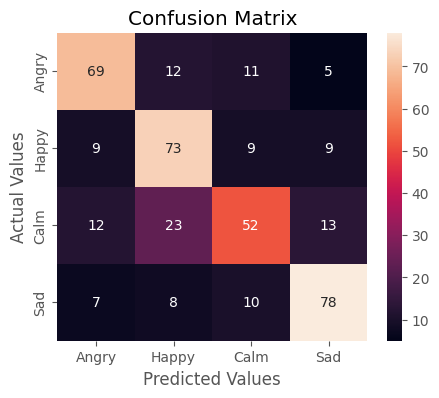

In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_test_new,y_p))
cm=(confusion_matrix(y_test_new,y_p))

cm_df = pd.DataFrame(cm,
                     index = ['Angry','Happy','Calm', 'Sad'],
                     columns = ['Angry','Happy','Calm', 'Sad'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [27]:
mn_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08,
    'hidden_layer_sizes': (150,50,3),
    'learning_rate': 'adaptive',
    'max_iter': 500,
}
# initialize Multi Layer Perceptron classifier
# with best parameters ( so far )
m2 = MLPClassifier(**mn_params)

# train the model
print("[*] Training the model...")
m2.fit(X_train_new, y_train_new)

# predict 25% of data to measure how good we are
y_p2 = m2.predict(X_test_new)

# calculate the accuracy
accuracy = accuracy_score(y_true=y_test_new, y_pred=y_p2)

print("Accuracy: {:.2f}%".format(accuracy*100))





[*] Training the model...
Accuracy: 66.50%


              precision    recall  f1-score   support

       angry       0.71      0.85      0.77        97
        calm       0.59      0.61      0.60       100
       happy       0.61      0.47      0.53       100
         sad       0.72      0.74      0.73       103

    accuracy                           0.67       400
   macro avg       0.66      0.67      0.66       400
weighted avg       0.66      0.67      0.66       400



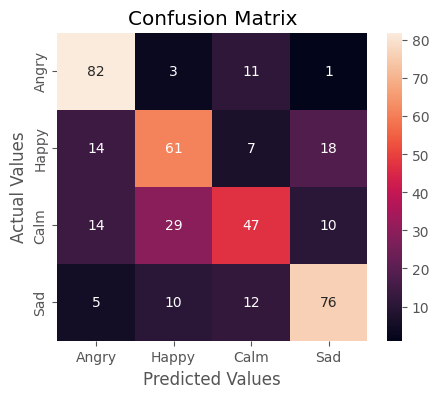

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming y_p2 is the predicted values

# Print classification report
print(classification_report(y_test_new, y_p2))

# Create and display the confusion matrix
cm = confusion_matrix(y_test_new, y_p2)
cm_df = pd.DataFrame(cm,
                     index=['Angry', 'Happy', 'Calm', 'Sad'],
                     columns=['Angry', 'Happy', 'Calm', 'Sad'])
plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


Text(0, 0.5, 'F1 Score')

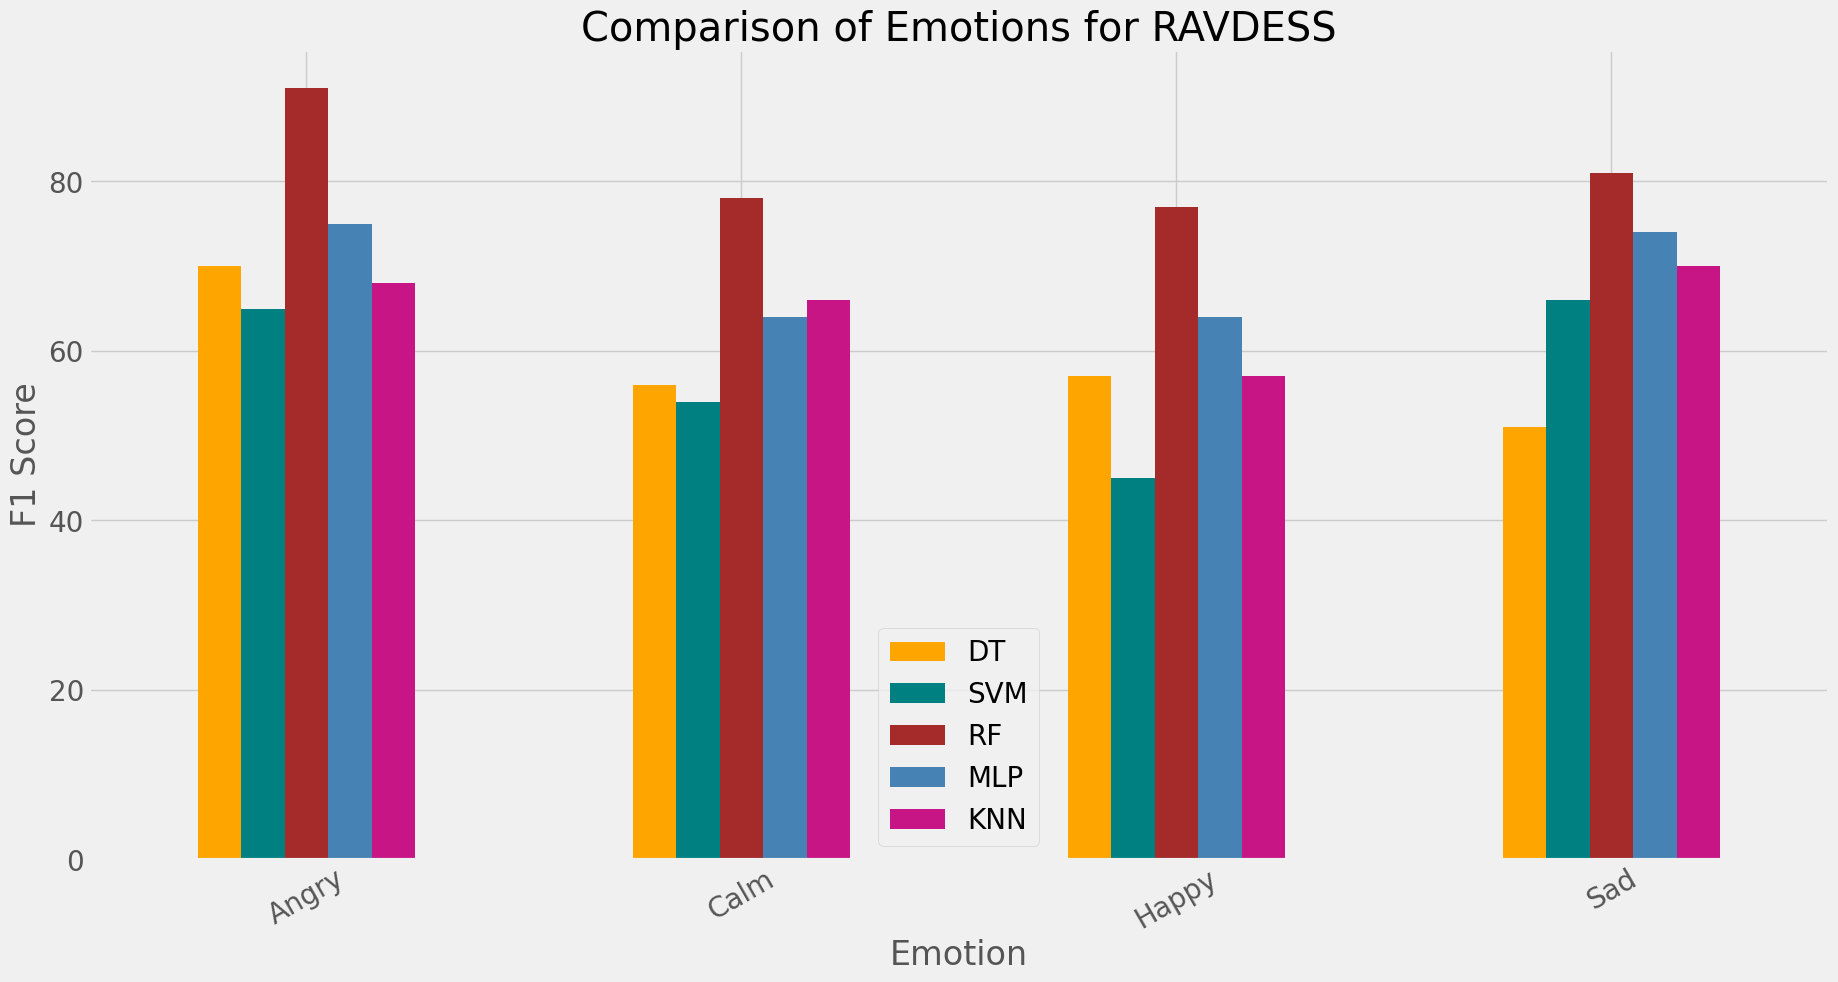

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.style.use('fivethirtyeight')
# plotdata = pd.DataFrame({
    
#     "DT":[70,56,57,51],
#     "SVM":[65,54,45,66],
#     "RF":[91,78,77,81],
#     "MLP":[75,64,64,74],
#     "KNN":[68,66,57,70]
#     #"CNN":[69,71,43,77],
#     #"XGBoost":[75,70,69,70]
# },

# index=["Angry","Calm","Happy", "Sad"])
# plt.rcParams.update({'font.size': 20})
# plotdata.plot(kind="bar",figsize=(20, 10),  color=['orange', 'teal', 'brown', 'steelblue', 'mediumvioletred',
#                     'purple', 'salmon'])
# plt.xticks(rotation=30, horizontalalignment="center")
# plt.title("Comparison of Emotions for RAVDESS")

# plt.xlabel("Emotion")

# plt.ylabel("F1 Score")

In [ ]:
# import pandas as pd

# plotdata = pd.DataFrame({
#     "DT":[70,56,57,51],
#     "SVM":[65,54,45,66],
#     "RF":[91,78,77,81],
#     "MLP":[75,64,64,74],
#     "KNN":[68,66,57,70]
# }, index=["Angry", "Calm", "Happy", "Sad"])

# # Calculate mean F1 score for each model
# mean_f1_score = plotdata.mean(axis=0)

# # Sort models based on mean F1 score
# sorted_models = mean_f1_score.sort_values(ascending=False)

# # Select the top two models
# best_models = sorted_models.head(2)

# # Print the best models
# print("Best Models based on F1 Score:")
# print(best_models)

Best Models based on F1 Score:
RF     81.75
MLP    69.25
dtype: float64
